In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data as Data
import torch.nn as nn

In [2]:
# 定义dataset
class my_Dataset(Data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

In [3]:
class WindDataset:
    def __init__(self,predict_step=3,label=6):
        self.raw_data = np.array(pd.read_excel("weather.xlsx")).astype(np.float)
        # 数据标准化
        self.predict_step = predict_step
        self.label = label
        self.min = self.raw_data.min()
        self.max = self.raw_data.max()
        self.data = (self.raw_data - self.min) / (self.max - self.min)

    def denormalize(self, x):
        return x * (self.max - self.min) + self.min

    def construct_set(self, train_por=0.65,val_por=0.2,test_por=0.15, window_size=50):
        train_x = []
        train_y = []
        val_x = []
        val_y = []
        test_x = []
        test_y = []
        len_train = int(self.data.shape[0] * train_por)
        print("len_train",len_train)
        len_val = int(self.data.shape[0] * val_por)
        len_test = int(self.data.shape[0] * test_por)
        train_seqs = self.data[:len_train]
        val_seqs = self.data[len_train:len_val+len_train]
        test_seqs = self.data[len_train+len_val:len_val+len_train+len_test]

        for i in range(train_seqs.shape[0] - window_size+1-self.predict_step):
            train_x.append(train_seqs[i:i+window_size, :])
            train_y.append(train_seqs[i+window_size:i+window_size+self.predict_step,self.label])

        for i in range(val_seqs.shape[0] - window_size+1-self.predict_step):
            val_x.append(val_seqs[i:i+window_size, :])
            val_y.append(val_seqs[i+window_size:i+window_size+self.predict_step,self.label])

        for i in range(test_seqs.shape[0] - window_size+1-self.predict_step):
            test_x.append(test_seqs[i:i+window_size, :])
            test_y.append(test_seqs[i+window_size:i+window_size+self.predict_step,self.label])
        train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))
        return train_set, val_set, test_set

In [4]:
WindData = WindDataset()
train_set, val_set, test_set = WindData.construct_set()
batch_size = 16
train_loader = Data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
val_loader = Data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)
test_loader = Data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)

len_train 347


/tmp/ipykernel_197831/1111329615.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.raw_data = np.array(pd.read_excel("weather.xlsx")).astype(np.float)
/tmp/ipykernel_197831/1111329615.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))


In [5]:
class My_LSTM(nn. Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        #gates将四个W拼接在一起
        self.gates = nn.Linear(input_size + hidden_size, hidden_size * 4)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn. Tanh()
        #output可以得到指定维度的输出，方便进行多步预测
        self.output = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        h, c = (torch.zeros(batch_size, self.hidden_size).to(x.device) for _ in range(2))
        y_list = []
        for i in range(seq_len):
            #这一时刻的输入与上一时刻的输出按照最后一维拼接送入大门，按照最后一维将大门输出分成四个小门
            forget_gate, input_gate, output_gate, candidate_cell = self.gates(torch.cat([x[:, i, :], h], dim=-1)).chunk(4, dim=-1)
            forget_gate, input_gate, output_gate = (self.sigmoid(g) for g in (forget_gate, input_gate, output_gate))#激活函数
            c = forget_gate * c + input_gate * self.tanh(candidate_cell)
            h = output_gate * self.tanh(c)
            y_list.append(self.output(h))
        return torch.stack(y_list, dim=1), (h, c)

In [15]:
device = torch.device("cuda")
input_size = train_set.X.shape[-1]
hidden_size = 256#8的倍数
output_size = 3
lr = 0.0001
epochs = 50
loss = nn.MSELoss()
my_lstm = My_LSTM(input_size, hidden_size, output_size).to(device)
optimizer = torch.optim.Adam(my_lstm.parameters(), lr)

In [7]:
from sklearn.metrics import mean_squared_error , mean_absolute_error #平均均方误差/平均绝对误差
import math
#mean_absolute_percentage_error 平均绝对百分比误差
def mean_absolute_percentage_error(y, pred):
    mask = y != 0
    y = y[mask]
    pred = pred[mask]
    mape = np.abs((y - pred) / y)
    mape = np.mean(mape) * 100
    return mape


def eval(y, pred):
    y = y.cpu().numpy()
    pred = pred.cpu().numpy()
    mse = mean_squared_error(y, pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y, pred)
    mape = mean_absolute_percentage_error(y, pred)
    return [rmse, mae, mape]

In [13]:
def evaluate(net,data_iter, loss, denormalize_fn, device='cuda:0'):
    rmse, mae, mape = 0, 0, 0
    batch_count = 0
    total_loss = 0.0
    net.eval()
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        output,_ = net(X)
        y_hat = output[:, -1, :].squeeze(-1)
        l = loss(y_hat, y.long())
        y = denormalize_fn(y)
        y_hat = denormalize_fn(y_hat)
        a, b, c = eval(y.detach(), y_hat.detach())
        rmse += a
        mae += b
        mape += c
        total_loss += l.detach().cpu().numpy().tolist()
        batch_count += 1
    return [rmse / batch_count, mae / batch_count, mape / batch_count], total_loss / batch_count

In [14]:
import time 
def train(net, train_iter, val_iter, test_iter, loss_fn, denormalize_fn, optimizer, num_epoch,device='cuda:0'):
    train_loss_lst = []
    val_loss_lst = []
    train_score_lst = []
    val_score_lst = []
    epoch_time = []
    net.train()
    for epoch in range(num_epoch):
        epoch_loss = 0
        batch_count = 0
        batch_time = []
        rmse, mae, mape = 0, 0, 0
        for X, Y in train_iter:
            #print("X:",X.shape)
            #print("Y:",Y.shape)
            batch_s = time.time()
            X = X.to(device).float()
            Y = Y.to(device).float()
            optimizer.zero_grad()
            output,_ = net(X)
            y_hat = output[:, -1, :].squeeze(-1)
            #print("y_hat",y_hat.shape)
            #print("y_hat:",y_hat)
            #print("Y:",Y)
            loss = loss_fn(y_hat, Y)
            loss.backward()
            optimizer.step()

            Y = denormalize_fn(Y)
            y_hat = denormalize_fn(y_hat)
            a, b, c = eval(Y.detach(), y_hat.detach())
            rmse += a
            mae += b
            mape += c
            epoch_loss += loss.detach().cpu().numpy().tolist()
            batch_count += 1

            batch_time.append(time.time() - batch_s)

        train_loss = epoch_loss / batch_count
        train_loss_lst.append(train_loss)
        train_score_lst.append([rmse/batch_count, mae/batch_count, mape/batch_count])

        # 验证集
        val_score, val_loss = evaluate(net, val_iter, loss_fn, denormalize_fn, device)
        val_score_lst.append(val_score)
        val_loss_lst.append(val_loss)

        epoch_time.append(np.array(batch_time).sum())
        print('*** epoch%d, train loss %.8f, train rmse %.4f, val loss %.8f, val rmse %.6f, time use %.3fs' %(epoch + 1, train_loss, train_score_lst[-1][0], val_loss, val_score[0], epoch_time[-1]))

    # 输出最终训练结果
    print(f'\n{"*" * 40}\nFinal result:')
    print(f'Total time {np.array(epoch_time).sum():.2f}s')

    # 计算测试集效果
    test_score, test_loss = evaluate(net,test_iter, loss_fn, denormalize_fn, device)
    print('Test result:')
    print(f'Test RMSE: {test_score[0]}    Test MAE: {test_score[1]}    Test MAPE: {test_score[2]}')
    return train_loss_lst, val_loss_lst, train_score_lst, val_score_lst

In [10]:
import matplotlib.pyplot as plt
import numpy as np
def visualization(train_loss,val_loss):
    x1=np.linspace(0,len(train_loss),len(train_loss))
    plt.plot(x1,train_loss,label='train_loss',linewidth=1.5)
    plt.plot(x1,val_loss,label='test_loss',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

def plot_metric(score_log):
    score_log = np.array(score_log)

    plt.figure(figsize=(10, 6), dpi=300)
    plt.subplot(2, 2, 1)
    plt.plot(score_log[:, 0], c='#d28ad4')
    plt.ylabel('RMSE')

    plt.subplot(2, 2, 2)
    plt.plot(score_log[:, 1], c='#e765eb')
    plt.ylabel('MAE')

    plt.subplot(2, 2, 3)
    plt.plot(score_log[:, 2], c='#6b016d')
    plt.ylabel('MAPE')

    plt.show() 

In [16]:
train_loss_lst, val_loss_lst, train_score_lst, val_score_lst = train(my_lstm, train_loader, val_loader, test_loader,loss, WindData.denormalize, optimizer, epochs,device=device)

*** epoch1, train loss 0.00034666, train rmse 566.6719, val loss 0.00003360, val rmse 197.708983, time use 1.214s
*** epoch2, train loss 0.00004175, train rmse 218.0185, val loss 0.00006814, val rmse 161.824355, time use 1.010s
*** epoch3, train loss 0.00001531, train rmse 136.3725, val loss 0.00002064, val rmse 89.556106, time use 1.060s
*** epoch4, train loss 0.00001192, train rmse 119.7377, val loss 0.00001659, val rmse 91.830914, time use 1.042s
*** epoch5, train loss 0.00001214, train rmse 121.7050, val loss 0.00001956, val rmse 88.277675, time use 0.998s
*** epoch6, train loss 0.00001229, train rmse 122.0980, val loss 0.00003164, val rmse 87.432363, time use 1.100s
*** epoch7, train loss 0.00001228, train rmse 121.9809, val loss 0.00002151, val rmse 85.264625, time use 1.072s
*** epoch8, train loss 0.00001170, train rmse 119.1153, val loss 0.00002652, val rmse 80.666248, time use 1.094s
*** epoch9, train loss 0.00001161, train rmse 118.9015, val loss 0.00002937, val rmse 84.01891

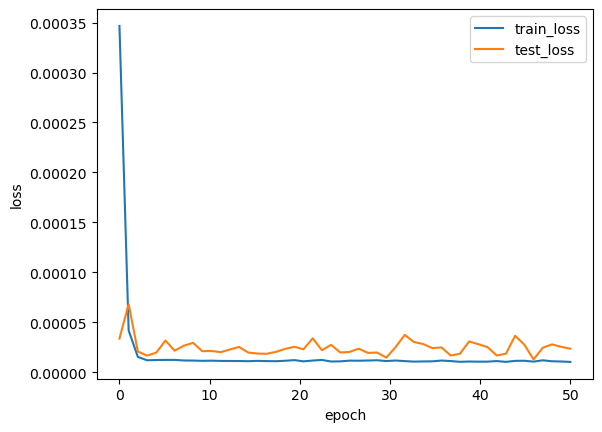

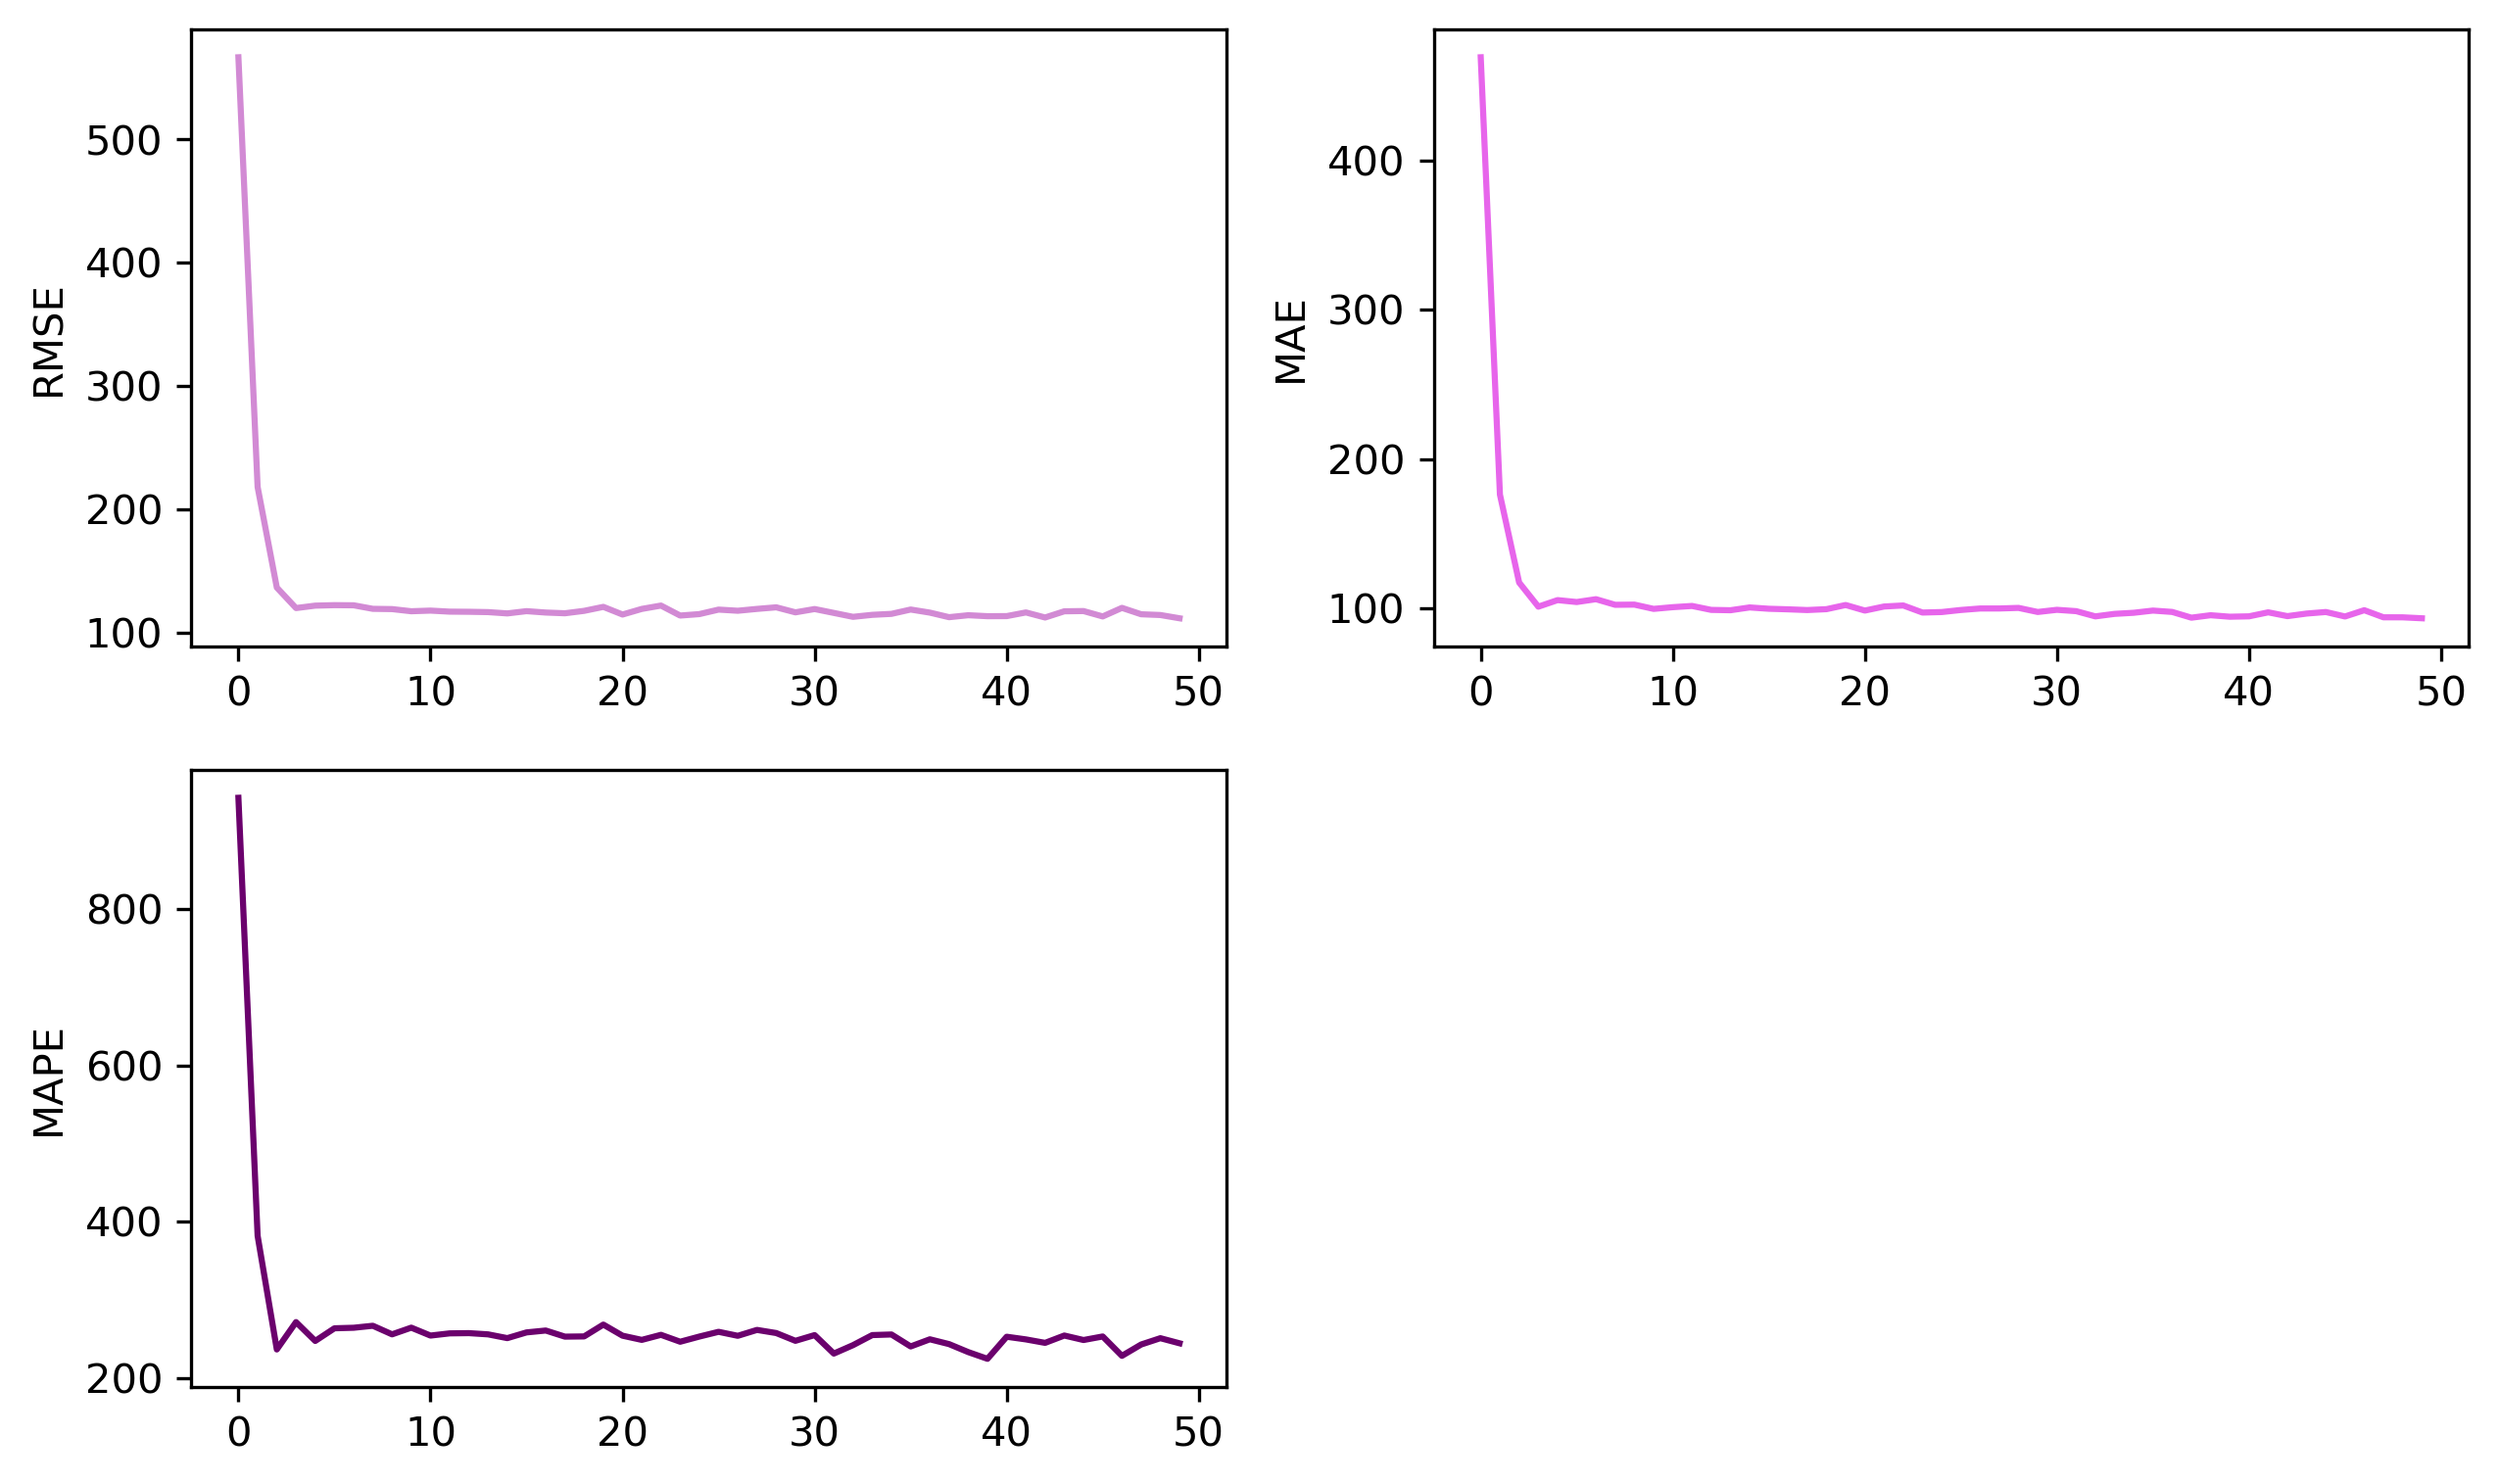

In [17]:
#RMSE和样本有关，RMSE大表示预测值和理论值的差值也大
visualization(train_loss_lst, val_loss_lst)
plot_metric(train_score_lst)